# DMC Example: Particle in 1D Box

We consider as a test case a particle in a 1D box. This is given by the Hamiltonian

$$
    H = -\frac{1}{2}\partial_x^2,
$$

for $x \in [0, 1]$, with homogeneous Dirichet boundary conditions. The exact ground state solution is

$$
    \psi_0(x) = \sin(\pi x),
$$

with energy

$$
    E_0 = \frac{\langle \psi_0 | H | \psi_0 \rangle}{\langle \psi_0 | \psi_0 \rangle} = \frac{\pi^2}{2} \approx 4.9348.
$$

As a trial function, we use

$$
    \psi_T(x) = x(1 - x),
$$

which has a variational energy

$$
    E_V = \frac{\langle \psi_T | H | \psi_T \rangle}{\langle \psi_T | \psi_T \rangle} = 5 > E_0.
$$

In [1]:
import sys
sys.path.insert(0, "../")
from pydmc import *
%matplotlib inline

In [2]:
nconf = 100
time_step = 1e-2
reference_energy = 5
blocks = 100
steps_per_block = 20
hamiltonian = lambda psi, x: -0.5 * psi.laplacian(x)

Next, we create the guiding wave function:

In [3]:
class GuidingWaveFunction(WaveFunction):

    def __call__(self, x):
        y = x[0]
        return y*(1 - y)

    def gradient(self, x):
        return gradient_fd(self, x)
    
    def laplacian(self, x):
        return laplacian_fd(self, x)

Next, we set up the branching algorithm and accept-reject algorithm, and construct the wave function:

In [4]:
brancher = SRBrancher()
#brancher = SimpleBrancher()
ar = DiffuseAcceptReject(fixed_node=True)
guiding_wf = GuidingWaveFunction()

Now, we generate a set of configurations. In a more advanced algorithm, this should be done by a short VMC run. Here, we just uniformly generate points $x \in [0, 1]$.

In [5]:
np.random.seed(0)
confs = [np.random.rand(1) for _ in range(nconf)]
walkers = [Walker(conf, 1.0) for conf in confs]

And finally, initialize the DMC runner and perform diffusion Monte Carlo.

In [6]:
dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy)
dmc.run_dmc(time_step, blocks, steps_per_block, neq=10)

The DMC energy estimate is updated and saved during the run. The last value of the estimate is the most accurate energy that was obtained. Additionally, an estimate on the error is computed; this is usually underestimated, so take care.

In [7]:
energy = dmc.energy_estimate[-1]
err = dmc.energy_error[-1]
print(f"Energy: {energy:.5f} +/- {err:.5f}")
print(f"Exact:  {np.pi**2/2:.5f}")

Energy: 4.94329 +/- 0.02141
Exact:  4.93480


Let's examine how the energy esimate behaves during the run:

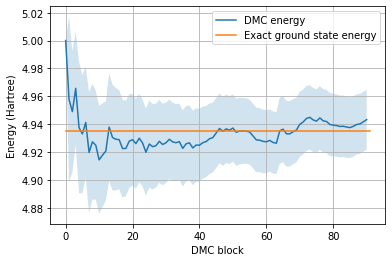

In [8]:
plt.figure()
ns = np.arange(0, len(dmc.energy_estimate))
plt.plot(ns, dmc.energy_estimate, label="DMC energy")
plt.fill_between(ns, dmc.energy_estimate - dmc.energy_error, dmc.energy_estimate + dmc.energy_error, alpha=0.2)

exact = np.pi**2/2                    
plt.plot([0, len(dmc.energy_estimate)], [exact, exact], label="Exact ground state energy")
plt.legend()
plt.xlabel("DMC block")
plt.ylabel("Energy (Hartree)")
plt.grid()

In [9]:
time_steps = np.linspace(0.5e-2, 1e-1, 5)
energies = []
errors = []

for tau in time_steps:
    np.random.seed(0)
    confs = [np.random.rand(1) for _ in range(nconf)]
    walkers = [Walker(conf, 1.0) for conf in confs]

    dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy)
    es = dmc.run_dmc(tau, blocks, steps_per_block, neq=10)
    energies.append(dmc.energy_estimate[-1])
    errors.append(dmc.energy_error[-1])

Extrapolated energy: 4.93602 +/- 0.02477


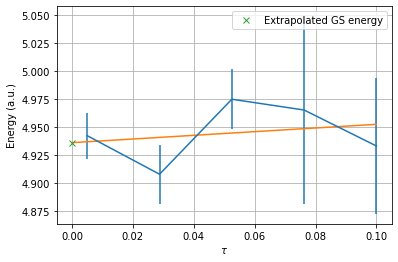

In [10]:
plt.figure()
plt.errorbar(time_steps, energies, yerr=errors)
# do a linear fit
f = lambda x, a, b: a*x + b
from scipy.optimize import curve_fit
(a, b), pcov = curve_fit(f, time_steps, energies)[0:2]
taus = np.linspace(0, time_steps[-1], 10)
plt.plot(taus, f(taus, a, b))
plt.plot(0, b, 'x', label="Extrapolated GS energy")
plt.grid()
plt.xlabel(r"$\tau$")
plt.ylabel("Energy (a.u.)")
plt.legend()
berr = math.sqrt(pcov[1, 1])
print(f"Extrapolated energy: {b:.5f} +/- {berr:.5f}")